<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/6_4_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.8.0'

# 1D 컨브넷 구현
케라스에서 1D 컨브넷은 Conv1D 층을 사용하여 구현합니다. Conv1D는 Conv2D와 인터페이스가 비슷합니다. (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용해 보죠.

기억을 되살리기 위해 데이터를 로드하고 전처리하는 코드를 다시 보겠습니다:

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


1D 컨브넷은 5장에서 사용한 2D 컨브넷과 비슷한 방식으로 구성합니다. Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링 층이나 Flatten 층으로 마칩니다. 이 구조는 3D 입력을 2D 출력으로 바꾸므로 분류나 회귀를 위해 모델에 하나 이상의 Dense 층을 추가할 수 있습니다.

한 가지 다른 점은 1D 컨브넷에 큰 합성곱 윈도우를 사용할 수 있다는 것입니다. 2D 합성곱 층에서 3 × 3 합성곱 윈도우는 3 × 3 = 9 특성을 고려합니다. 하지만 1D 합성곱 층에서 크기 3인 합성곱 윈도우는 3개의 특성만 고려합니다. 그래서 1D 합성곱에 크기 7이나 9의 윈도우를 사용할 수 있습니다.

다음은 IMDB 데이터셋을 위한 1D 컨브넷의 예입니다:

In [4]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 65s 410ms/step - loss: 0.7373 - acc: 0.5138 - val_loss: 0.6887 - val_acc: 0.5508
Epoch 2/10
157/157 [==============================] - 72s 459ms/step - loss: 0.6729 - acc: 0.6418 - val_loss: 0.6837 - val_acc: 0.5264
Epoch 3/10
157/157 [==============================] - 64s 410ms/step - loss: 0.6490 - acc: 0.7340 - val_loss: 0.6616 - val_acc: 0.6530
Epoch 4/10
157/157 [==============================] - 65s 414ms/step - loss: 0.6113 - acc: 0.8037 - val_loss: 0.6141 - val_acc: 0.7290
Epoch 5/10
157/157 [==============================] - 66s 420ms/step - loss: 0.5314 - acc: 0.8253 - val_loss: 0.5001 - val_acc: 0.7986
Epoch 6/10
157/157 [==============================] - 65s 415ms/step - loss: 0.4161 - acc: 0.8479 - val_loss: 0.4262 - val_acc: 0.8294
Epoch 7/10
157/157 [==============================] - 65s 413ms/step - loss: 0.3452 - acc: 0.8771 - val_loss: 0.4078 - val_acc: 0.8462
Epoch 8/10
157/157 [==============================] - 6

In [5]:
import matplotlib.pyplot as plt

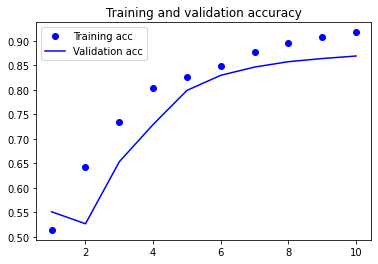

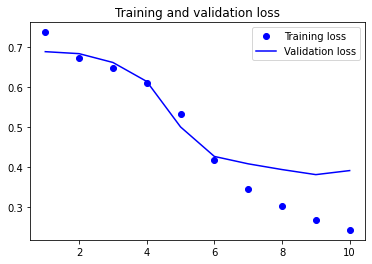

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# CNN과 RNN을 연결하여 긴 시퀀스를 처리하기
1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 (합성곱 윈도우 크기의 범위를 넘어선) 타임스텝의 순서에 민감하지 않습니다. 물론 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다. 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다. 이런 방법은 순서를 감지하기엔 부족합니다. 온도 예측 문제에 1D 컨브넷을 적용하여 이를 확인해 보겠습니다. 이 문제는 순서를 감지해야 좋은 예측을 만들어 낼 수 있습니다. 다음은 이전에 정의한 float_data, train_gen, val_gen, val_steps를 다시 사용합니다:

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
import os
import numpy as np

data_dir = './gdrive/MyDrive/datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 39s 77ms/step - loss: 0.4185 - val_loss: 0.4560
Epoch 2/20
500/500 [==============================] - 40s 80ms/step - loss: 0.3532 - val_loss: 0.4511
Epoch 3/20
500/500 [==============================] - 41s 83ms/step - loss: 0.3290 - val_loss: 0.4573
Epoch 4/20
500/500 [==============================] - 39s 78ms/step - loss: 0.3138 - val_loss: 0.4607
Epoch 5/20
500/500 [==============================] - 38s 76ms/step - loss: 0.3005 - val_loss: 0.4608
Epoch 6/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2940 - val_loss: 0.4752
Epoch 7/20
500/500 [==============================] - 38s 77ms/step - loss: 0.2885 - val_loss: 0.4892
Epoch 8/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2824 - val_loss: 0.4601
Epoch 9/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2741 - val_loss: 0.4692
Epoch 10/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2691 - val_los

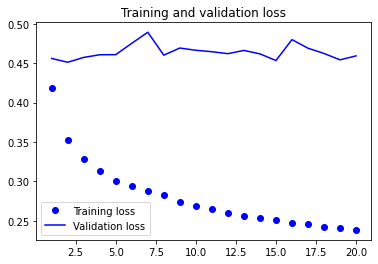

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 MAE는 0.40 대에 머물러 있습니다. 작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못 했습니다. 이는 컨브넷이 입력 시계열에 있는 패턴을 보고 이 패턴의 시간 축의 위치(시작인지 끝 부분인지 등)를 고려하지 않기 때문입니다. 최근 데이터 포인트일수록 오래된 데이터 포인트와는 다르게 해석해야 하기 때문에 컨브넷이 의미 있는 결과를 만들지 못합니다. 이런 컨브넷의 한계는 IMDB 데이터에서는 문제가 되지 않습니다. 긍정 또는 부정적인 감성과 연관된 키워드 패턴의 중요성은 입력 시퀀스에 나타난 위치와 무관하기 때문입니다.

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한가지 전략은 **1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것입니다.** 수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기엔 현실적으로 너무 긴 시퀀스를 다룰 때 특별히 도움이 됩니다. 컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 (다운 샘플된) 시퀀스로 변환합니다. 추출된 특성의 시퀀스는 RNN 파트의 입력이 됩니다.

이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다. 이 방법은 효과적이므로 많이 사용되기를 바랍니다. 온도 예측 문제에 적용해 보죠. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나(데이터 제너레이터의 lookback 매개변수를 증가시킵니다), 시계열 데이터를 더 촘촘히 바라볼 수 있습니다(제너레이터의 step 매개변수를 감소시킵니다). 여기서는 그냥 step을 절반으로 줄여서 사용하겠습니다. 온도 데이터가 30분마다 1 포인트씩 샘플링되기 때문에 결과 시계열 데이터는 두 배로 길어집니다. 앞서 정의한 제너레이터 함수를 다시 사용합니다.

In [13]:
# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

이 모델은 두 개의 Conv1D 층 다음에 GRU 층을 놓았습니다:

In [14]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


500/500 [==============================] - 169s 333ms/step - loss: 0.3303 - val_loss: 0.2920
Epoch 2/20
500/500 [==============================] - 167s 334ms/step - loss: 0.2972 - val_loss: 0.2791
Epoch 3/20
500/500 [==============================] - 166s 332ms/step - loss: 0.2824 - val_loss: 0.2865
Epoch 4/20
500/500 [==============================] - 166s 332ms/step - loss: 0.2729 - val_loss: 0.2800
Epoch 5/20
500/500 [==============================] - 166s 332ms/step - loss: 0.2643 - val_loss: 0.2908
Epoch 6/20
500/500 [==============================] - 165s 331ms/step - loss: 0.2587 - val_loss: 0.2825
Epoch 7/20
500/500 [==============================] - 165s 331ms/step - loss: 0.2521 - val_loss: 0.2918
Epoch 8/20
500/500 [==============================] - 165s 330ms/step - loss: 0.2444 - val_loss: 0.2895
Epoch 9/20
500/500 [==============================] - 165s 329ms/step - loss: 0.2406 - val_loss: 0.2946
Epoch 10/20
500/500 [==============================] - 165s 330ms/step - lo

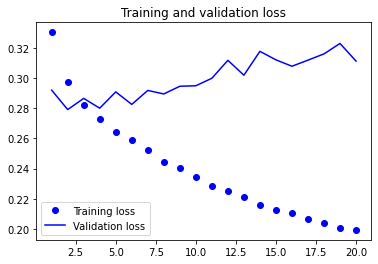

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 손실로 비교해 보면 이 설정은 규제가 있는 GRU 모델만큼 좋지는 않습니다. 하지만 훨씬 빠르기 때문에 데이터를 두 배 더 많이 처리할 수 있습니다. 여기서는 큰 도움이 안 되었지만 다른 데이터셋에서는 중요할 수 있습니다.